# 영업 성공 여부 분류 경진대회

## 1. 데이터 확인

### 필수 라이브러리

In [169]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

### 데이터 셋 읽어오기

In [170]:
df_train = pd.read_csv("train.csv") # 학습용 데이터
df_test = pd.read_csv("submission.csv") # 테스트 데이터(제출파일의 데이터)

In [171]:
df_train.head() # 학습용 데이터 살펴보기

,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,it_strategic_ver,...,response_corporate,expected_timeline,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted
0,1.0,/Quezon City/Philippines,AS,0.066667,32160,End-Customer,Enterprise,NaN,NaN,NaN,...,LGEPH,less than 3 months,1,0,0.003079,0.026846,corporate / office,Engineering,0,True
1,1.0,/PH-00/Philippines,AS,0.066667,23122,End-Customer,Enterprise,12.0,NaN,NaN,...,LGEPH,less than 3 months,1,0,0.003079,0.026846,corporate / office,Advertising,1,True
2,1.0,/Kolkata /India,AS,0.088889,1755,End-Customer,Enterprise,144.0,NaN,NaN,...,LGEIL,less than 3 months,1,0,0.003079,0.026846,corporate / office,Construction,2,True
3,1.0,/Bhubaneswar/India,AS,0.088889,4919,End-Customer,Enterprise,NaN,NaN,NaN,...,LGEIL,less than 3 months,1,0,0.003079,0.026846,corporate / office,IT/Software,3,True
4,1.0,/Hyderabad/India,AS,0.088889,17126,Specifier/ Influencer,Enterprise,NaN,NaN,NaN,...,LGEIL,less than 3 months,0,0,0.003079,0.026846,corporate / office,NaN,4,True


## 2. 데이터 전처리

In [172]:
print(df_train.shape, df_test.shape)

(59299, 29) (5271, 30)


In [173]:
print(df_train.shape, df_test.shape)

(59299, 29) (5271, 30)


### 무조건 converted하면서 test에 없는 회사인 25096은 삭제

In [174]:
del_id=[25096]
df_train=df_train[~df_train["customer_idx"].isin(del_id)]
df_train = df_train[(df_train["business_unit"] != "CM") & (df_train["business_unit"] != "Solution")]

### 문의를 한 횟수, 문의하면서 converted 한 횟수, converted한 비율을 회사별로 계산

In [175]:
df_cus = df_train.groupby("customer_idx")["is_converted"].count().reset_index()
df_real_cus = df_train.groupby("customer_idx")["is_converted"].sum().reset_index()
df = pd.merge(df_cus, df_real_cus, on="customer_idx")
df["cus_ratio"] = df["is_converted_y"] / df["is_converted_x"]
df = df.rename(columns={"is_converted_x": "cus_query_cnt", "is_converted_y" : "cus_converted_cnt"})
df = df[df["cus_query_cnt"]>=2] 
df_train = pd.merge(df_train, df, on='customer_idx', how="left")
df_test = pd.merge(df_test, df, on='customer_idx', how="left")

In [176]:
df_cus = df_train.groupby("lead_owner")["is_converted"].count().reset_index()
df_real_cus = df_train.groupby("lead_owner")["is_converted"].sum().reset_index()
df = pd.merge(df_cus, df_real_cus, on="lead_owner")
df["lead_ratio"] = df["is_converted_y"] / df["is_converted_x"]
df = df.rename(columns={"is_converted_x": "lead_query_cnt", "is_converted_y" : "lead_converted_cnt"})
df=df[df["lead_query_cnt"]>=2]  
df_train = pd.merge(df_train, df, on='lead_owner', how="left")
df_test = pd.merge(df_test, df, on='lead_owner', how="left")

In [177]:
def country_name(x):
    if pd.isnull(x):
        return 0
    else:
        a = x.split("/")
        return a[-1]

df_train["customer_country"]=df_train["customer_country"].apply(country_name)
df_train["customer_country.1"]=df_train["customer_country.1"].apply(country_name)
df_test["customer_country"]=df_test["customer_country"].apply(country_name)
df_test["customer_country.1"]=df_test["customer_country.1"].apply(country_name)

### 레이블 인코딩

In [178]:
def label_encoding(series: pd.Series) -> pd.Series:
    """범주형 데이터를 시리즈 형태로 받아 숫자형 데이터로 변환합니다."""

    my_dict = {}

    # 모든 요소를 문자열로 변환
    series = series.astype(str)

    for idx, value in enumerate(sorted(series.unique())):
        my_dict[value] = idx
    series = series.map(my_dict)

    return series

In [179]:
# 레이블 인코딩할 칼럼들
label_columns = [
    "customer_country",
    "business_subarea",
    # "business_area",
    # "business_unit",
    "customer_type",
    # "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_country.1",
    "customer_position",
    "response_corporate",
    "expected_timeline",
]

#원핫 인코딩할 칼럼들
one_hot_columns=[
    # "customer_country",
    # "business_subarea",
    "business_area",
    "business_unit",
    # "customer_type",
    "enterprise",
    # "customer_job",
    # "inquiry_type",
    # "product_category",
    # "product_subcategory",
    # "product_modelname",
    # "customer_country.1",
    # "customer_position",
    # "response_corporate",
    # "expected_timeline",    
]

df_all = pd.concat([df_train, df_test])

for col in label_columns:
    df_all[col] = label_encoding(df_all[col])
    
df_all = pd.get_dummies(df_all, columns=one_hot_columns)

In [180]:
# "com_reg_ver_win_rate"

In [181]:
drop_columns=[ 
            #   "id_strategic_ver", 
            #   "it_strategic_ver", 
            #   "idit_strategic_ver",
            #   "ver_cus",
            #   "ver_pro", 
            # "ver_win_rate_x", 
            # "ver_win_ratio_per_bu",
            # "expected_timeline",
            # "com_reg_ver_win_rate"
            ]

for column in drop_columns:
    df_all.drop(columns=column, inplace=True)

다시 학습 데이터와 제출 데이터를 분리합니다.

In [182]:
df_train = df_all.iloc[: len(df_train)]
df_test = df_all.iloc[len(df_train) :]

In [183]:
df_train = df_train.fillna(0)
df_test = df_test.fillna(0)

In [184]:
df_train=df_train.drop(columns="id")

In [185]:
df_train.shape

(56582, 49)

In [186]:
X_train= df_train.drop("is_converted", axis=1)
y_train= df_train["is_converted"]
X_test = df_test.drop(["is_converted", "id"], axis=1)

In [187]:
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

## 3. 모델 학습

### 모델 정의 

In [188]:
y_train.unique()

array([1, 0], dtype=int64)

In [189]:
params={
    'objective': 'binary',
    'learning_rate':0.01,
    "random_state":0,
}

In [190]:
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

# model = DecisionTreeClassifier(random_state=0)
model = LGBMClassifier(**params, class_weight={0: 10, 1:1})
# model = XGBClassifier(random_state=0)
# model = MLPClassifier(random_state=0)

## 베이스라인 모델

In [191]:
from sklearn. model_selection import StratifiedKFold
import lightgbm as lgb
from sklearn.metrics import f1_score

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

oof_val_preds = np.zeros(X_train.shape[0])
oof_test_preds = np.zeros(X_test.shape[0])

def f1score(preds, d_train):
    labels = d_train.get_label()
    return 'f1', f1_score(labels, np.round(preds)), True

params={
    'objective': 'binary',
    'learning_rate':0.01,
    "random_state":0,
    "early_stopping_rounds":100,
    "scale_pos_weight": 5
}

f1_score_list=[]
feature_importance_list=[]

for idx, (train_idx, valid_idx) in enumerate(folds.split(X_train, y_train)):
    print('#'*40, f'폴드{idx+1} / 폴드{folds.n_splits}', "#"*40)
    X_tr, y_tr = X_train.iloc[train_idx], y_train.iloc[train_idx]
    X_val, y_val = X_train.iloc[valid_idx], y_train.iloc[valid_idx]
    
    d_train = lgb.Dataset(X_tr, y_tr)
    d_valid = lgb.Dataset(X_val, y_val)
    
    lgb_model = lgb.train(params=params,
                          train_set=d_train,
                          num_boost_round=1000,
                          valid_sets=d_valid,
                          feval=f1score)
    
    oof_test_preds += lgb_model.predict(X_test) / folds.get_n_splits()
    oof_val_preds[valid_idx] += lgb_model.predict(X_val)
    
    f1 = f1_score(y_val, np.round(oof_val_preds[valid_idx]))
    f1_score_list.append(f1)
    print(f'폴드 {idx+1} f1 score: {f1}\n')
    
    feature_importance_list.append(lgb_model.feature_importance())
    
print(f'검증 평균 f1 score: {np.mean(f1_score_list)}')
# 검증 평균 f1 score:  0.7694154228409034

######################################## 폴드1 / 폴드5 ########################################
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1942, number of negative: 43323
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002819 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3029
[LightGBM] [Info] Number of data points in the train set: 45265, number of used features: 48
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.042903 -> initscore=-3.104965
[LightGBM] [Info] Start training from score -3.104965
Training until validation scores don't improve for 100 rounds


Early stopping, best iteration is:
[105]	valid_0's binary_logloss: 0.070087	valid_0's f1: 0.751553
폴드 1 f1 score: 0.751552795031056

######################################## 폴드2 / 폴드5 ########################################
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1942, number of negative: 43323
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002239 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3048
[LightGBM] [Info] Number of data points in the train set: 45265, number of used features: 48
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.042903 -> initscore=-3.104965
[LightGBM] [Info] Start training from score -3.104965
Training until validation scores don't improve for 100 rou

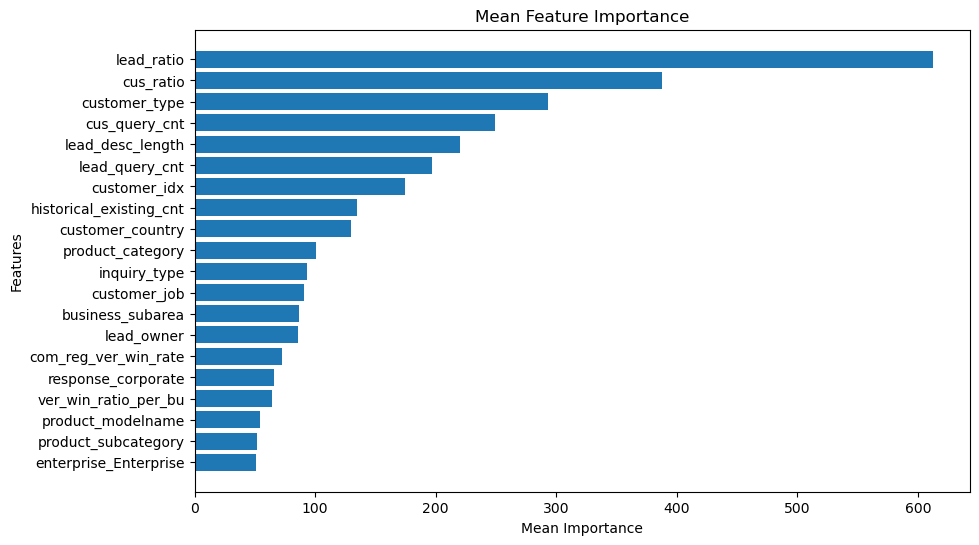

In [192]:
import numpy as np
import matplotlib.pyplot as plt

# 특징 중요도와 특징 이름을 정렬
top_features = 20
sorted_indices = np.argsort(-np.mean(feature_importance_list, axis=0))[::-1]
sorted_feature_names = [lgb_model.feature_name()[i] for i in sorted_indices][-top_features:]
sorted_mean_importance = np.mean(feature_importance_list, axis=0)[sorted_indices][-top_features:]

# 바 차트 그리기
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_mean_importance)
plt.xlabel('Mean Importance')
plt.ylabel('Features')
plt.title('Mean Feature Importance')
plt.show()

### 테스트 데이터 예측

In [193]:
# 예측에 필요한 데이터 분리
test_pred = np.where(oof_test_preds >= 0.5, 1, 0)

In [194]:
sum(test_pred) # True로 예측된 개수 1038

1055

## 4. 제출하기

### 제출 파일 작성

In [195]:
df_test["is_converted"] = test_pred

In [196]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["is_converted"]=df_test["is_converted"]

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

**우측 상단의 제출 버튼을 클릭해 결과를 확인하세요**